In [4]:
# this git is for model quantization performenace test.

import tensorflow as tf
import tensorflow_datasets as tfds

dataset = tfds.load('mnist', data_dir="F:\\dataset\\")
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
img_size = 96
class_num = 10
batch_size = 16

In [6]:
def data_preprocess(batch):
    images = batch['image']
    labels = batch['label']
    images = tf.image.resize(images, (img_size, img_size))
    return images, labels

train_dataset = dataset['train']
test_dataset = dataset['test']
train_data_num = train_dataset.cardinality()
test_data_num = test_dataset.cardinality()
train_dataset = train_dataset.map(data_preprocess).batch(batch_size)
test_dataset = test_dataset.map(data_preprocess).batch(batch_size)
print(f'train data num:{train_data_num} \ntest data num:{test_data_num}')


train data num:60000 
test data num:10000


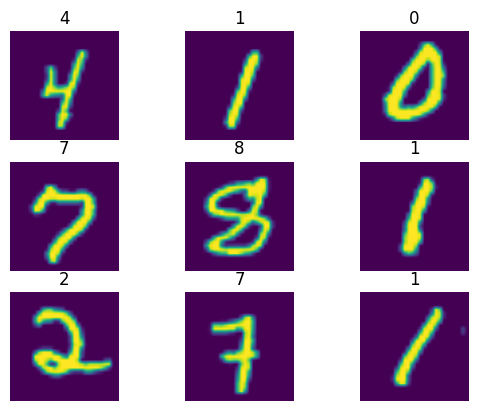

In [129]:
# visualize sample data
import matplotlib.pyplot as plt


sample = next(iter(train_dataset))

fig, ax = plt.subplots(3,3)
for i in range(9):
    img = sample[0][i]
    img = tf.cast(img, tf.uint8)
    label = sample[1][i].numpy()
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title(label)

In [130]:
# build a model
backbone = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False)
backbone.trainable = False
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_size, img_size, 1)),
    tf.keras.layers.Conv2D(256,3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(class_num),
    tf.keras.layers.Softmax(),
])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 96, 96, 256)       2560      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 48, 48, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 48, 48, 128)       295040    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 12, 12, 64)      

In [131]:
# train the model
samples = next(iter(test_dataset))
item = samples[0][0]
classes = set()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.sparse_categorical_crossentropy, 
metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_dataset, epochs = 5)
model.evaluate(test_dataset)

Epoch 1/5
 33/235 [===>..........................] - ETA: 20s - loss: 3.5045 - sparse_categorical_accuracy: 0.3151

KeyboardInterrupt: 

In [122]:
model.save('2d_classification_model')

INFO:tensorflow:Assets written to: 2d_classification_model\assets


INFO:tensorflow:Assets written to: 2d_classification_model\assets


In [7]:
# quantize model and save the model
def sample_gen():
    sample = next(iter(train_dataset.take(1)))
    for s in sample[0]:
        yield [s[None,...]]

converter = tf.lite.TFLiteConverter.from_saved_model("2d_classification_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = sample_gen
tflite_model = converter.convert()
open("quantized_2d_classification_model","wb").write(tflite_model)

419856

In [8]:
# import the quantized model.
interpreter = tf.lite.Interpreter('quantized_2d_classification_model')
inputs = interpreter.get_input_details()[0]
outputs = interpreter.get_output_details()[0]
interpreter.resize_tensor_input(inputs['index'],(batch_size, img_size, img_size, 1))
interpreter.allocate_tensors()

model = tf.keras.models.load_model('2d_classification_model')

In [11]:
# evaluate performance of the quantized model.
import time
test_dataset = test_dataset.unbatch().batch(batch_size)
samples = test_dataset.take(1)
sample = next(iter(samples))
interpreter.set_tensor(inputs['index'], sample[0])
interpreter.invoke()

#compute prediction and accuracy.
predict_quantized_model = interpreter.get_tensor(outputs['index'])
acc = tf.losses.sparse_categorical_crossentropy(sample[1], predict_quantized_model)
acc_quantized_model = tf.math.reduce_mean(acc).numpy()

predict_float_model = model.predict(sample[0])
acc = tf.losses.sparse_categorical_crossentropy(sample[1], predict_float_model)
acc_float_model = tf.math.reduce_mean(acc).numpy()

print(f"float model loss : {acc_float_model}")
print(f"quantized model loss : {acc_quantized_model}")

1/1 [==============================] - 0s 16ms/step
float model accuracy : 0.0003335755900479853%
quantized model accuracy : 9.98377345240442e-07%
